## Example for CESM2 Climate Change

Here, we load present (2016-01-02 to 2035-12-31) and future (2066-01-02 to 2085-12-31) data, and evaluate the applicability of a machine learning model trained on the present climate for predicting future urban climate.

**NOTE**: Compared to the CESM1 demo, here "Q" (QBOT), "U" (UBOT) and "V" (VBOT) are not included. When the bottom "lev" of "Q", "U", and "V" are merged, there is an issue.   

Reference:     
- GitHub: https://github.com/NCAR/cesm2-le-aws    
- Data/Variables Information: https://ncar.github.io/cesm2-le-aws/model_documentation.html#data-catalog       
- Reproduce CESM-LENS: https://github.com/NCAR/cesm2-le-aws/blob/main/notebooks/kay_et_al_lens2.ipynb   

**Step 0: load necessary packages and define parameters (no need to change)**

In [1]:
%%time
# Display output of plots directly in Notebook
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import json
from flaml import AutoML
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import math
import seaborn as sns
import util
import gc

import warnings
warnings.filterwarnings("ignore")

CPU times: user 1.76 s, sys: 338 ms, total: 2.1 s
Wall time: 2.1 s


/glade/work/zhonghua/miniconda3/envs/aws_urban/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Step 1: load future data (2066-01-02 to 2085-12-31)

In [2]:
with open("./config_cesm2_climate_future.json",'r') as load_f:
#     param = json.loads(json.load(load_f))
    param = json.load(load_f)
    
    model = param["model"] # cesm2
    urban_type = param["urban_type"] # md
    city_loc = param["city_loc"] # {"lat": 40.0150, "lon": -105.2705}
    l_component = param["l_component"]
    a_component = param["a_component"]
    experiment = param["experiment"]
    frequency = param["frequency"]
    cam_ls = param["cam_ls"]
    clm_ls = param["clm_ls"]
    forcing_variant = param["forcing_variant"]
    time = slice(param["time_start"],param["time_end"])
    member_id = param["member_id"]
#     estimator_list = param["estimator_list"]
#     time_budget = param["time_budget"]
    features = param["features"]
    label = param["label"]
    clm_var_mask = param["label"][0]
    
# get a dataset
ds = util.get_data(model, city_loc, experiment, frequency, member_id, time, cam_ls, clm_ls,
                   forcing_variant=forcing_variant, urban_type=urban_type)

# create a dataframe
ds['time'] = ds.indexes['time'].to_datetimeindex()
df_future = ds.to_dataframe().reset_index().dropna()

if "PRSN" in features:
    df_future["PRSN"] = df_future["PRECSC"] + df_future["PRECSL"]
if "PRECT" in features:
    df_future["PRECT"] = df_future["PRECC"] + df_future["PRECL"]

X_future_train, X_future_test, y_future_train, y_future_test = train_test_split(
    df_future[features], df_future[label], test_size=0.05, random_state=66)
display(X_future_train.head())
display(y_future_train.head())
    
del ds
gc.collect()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


different lat between CAM and CLM subgrid info, adjust subgrid info's lat


,FLNS,FSNS,PRECT,PRSN,TREFHT,TREFHTMX,TREFHTMN
3141,132.101913,282.795959,1.133692e-18,1.683445e-22,301.627167,308.214355,294.433472
3374,102.263107,232.231064,1.288310e-09,3.225936e-17,282.054474,290.421173,275.131805
4966,84.371529,157.059128,4.308776e-09,5.351772e-24,301.114380,308.091553,295.771759
4898,112.747520,312.061737,3.106702e-12,1.646209e-16,293.713379,300.738068,286.623810
257,103.962410,219.334702,1.838627e-12,2.581992e-19,293.866547,303.037964,285.171997


,TREFMXAV
3141,308.828857
3374,291.491394
4966,308.434662
4898,302.386292
257,303.614197


1157

### Step 2: load present data (2016-01-02 to 2035-12-31)

In [3]:
with open("./config_cesm2_climate_present.json",'r') as load_f:
#     param = json.loads(json.load(load_f))
    param = json.load(load_f)
    
    model = param["model"] # cesm2
    urban_type = param["urban_type"] # md
    city_loc = param["city_loc"] # {"lat": 40.0150, "lon": -105.2705}
    l_component = param["l_component"]
    a_component = param["a_component"]
    experiment = param["experiment"]
    frequency = param["frequency"]
    cam_ls = param["cam_ls"]
    clm_ls = param["clm_ls"]
    forcing_variant = param["forcing_variant"]
    time = slice(param["time_start"],param["time_end"])
    member_id = param["member_id"]
    estimator_list = param["estimator_list"]
    time_budget = param["time_budget"]
    features = param["features"]
    label = param["label"]
    clm_var_mask = param["label"][0]
    
# get a dataset
ds = util.get_data(model, city_loc, experiment, frequency, member_id, time, cam_ls, clm_ls,
                   forcing_variant=forcing_variant, urban_type=urban_type)

# create a dataframe
ds['time'] = ds.indexes['time'].to_datetimeindex()
df_present = ds.to_dataframe().reset_index().dropna()

if "PRSN" in features:
    df_present["PRSN"] = df_present["PRECSC"] + df_present["PRECSL"]
if "PRECT" in features:
    df_present["PRECT"] = df_present["PRECC"] + df_present["PRECL"]

X_present_train, X_present_test, y_present_train, y_present_test = train_test_split(
    df_present[features], df_present[label], test_size=0.05, random_state=66)
display(X_present_train.head())
display(y_present_train.head())
    
del ds
gc.collect()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


different lat between CAM and CLM subgrid info, adjust subgrid info's lat


,FLNS,FSNS,PRECT,PRSN,TREFHT,TREFHTMX,TREFHTMN
3141,68.676613,199.265472,1.852086e-08,2.289983e-20,291.946472,300.030487,287.180969
3374,94.056053,220.666367,6.313760e-09,6.944248e-15,277.478851,284.147064,274.174713
4966,114.924210,275.390778,8.211864e-11,1.427359e-19,298.891174,307.201935,290.399048
4898,121.778847,326.139313,1.517838e-10,8.360884e-20,288.308014,294.743103,280.171753
257,89.618881,217.455154,1.282198e-11,1.113258e-15,283.563782,295.233582,277.655365


,TREFMXAV
3141,300.976105
3374,285.210724
4966,307.383545
4898,296.533691
257,296.322083


1503

### Step 3: compare future and present training data

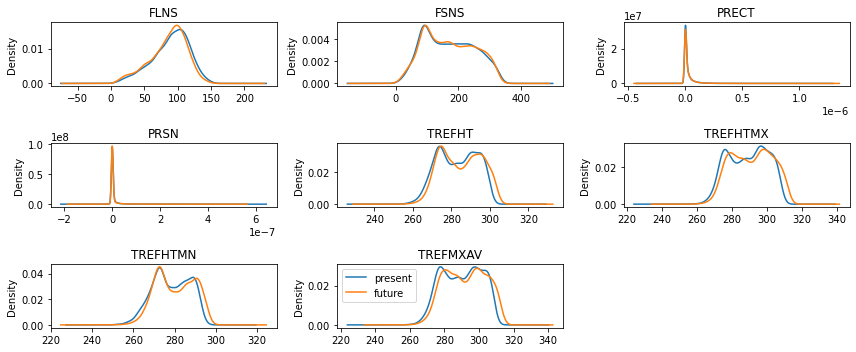

In [4]:
fig = plt.figure(figsize=(12,5))
idx = 1
for var in features:
    ax = fig.add_subplot(math.ceil(math.ceil(len(features)/3)), 3, idx)
    X_present_train[var].plot.kde(ax=ax)
    X_future_train[var].plot.kde(ax=ax)
    idx+=1
    ax.set_title(var)

var = "TREFMXAV"
ax = fig.add_subplot(math.ceil(math.ceil(len(features)/3)), 3, idx)
y_present_train[var].plot.kde(ax=ax, label="present")
y_future_train[var].plot.kde(ax=ax, label="future")
ax.set_title(var)
plt.legend()

plt.tight_layout()
plt.show()

### Step 4: automated machine learning

**train a model (emulator)**

In [5]:
%%time
# setup for automl
automl = AutoML()
automl_settings = {
    "time_budget": time_budget,  # in seconds
    "metric": 'r2',
    "task": 'regression',
    "estimator_list":estimator_list,
}

# train the model
automl.fit(X_train=X_present_train, y_train=y_present_train.values,
           **automl_settings, verbose=-1)
print(automl.model.estimator)

# evaluate the model
y_present_pred = automl.predict(X_present_test)
print("root mean square error:",
      round(mean_squared_error(y_true=y_present_test, y_pred=y_present_pred, squared=False),3))
print("r2:",
      round(r2_score(y_true=y_present_test, y_pred=y_present_pred),3))

LGBMRegressor(learning_rate=0.07667973275997925, max_bin=1023,
              min_child_samples=2, n_estimators=141, num_leaves=11,
              reg_alpha=0.006311706639004055, reg_lambda=0.048417038177217056,
              verbose=-1)
root mean square error: 0.53
r2: 0.998
CPU times: user 7min 14s, sys: 7.27 s, total: 7min 21s
Wall time: 30.1 s


**apply the model to future climate and evaluate**

In [6]:
y_future_pred = automl.predict(X_future_test)
print("root mean square error:",
      round(mean_squared_error(y_true=y_future_test, y_pred=y_future_pred, squared=False),3))
print("r2:",
      round(r2_score(y_true=y_future_test, y_pred=y_future_pred),3))

root mean square error: 0.741
r2: 0.995


**use the future climate data to train and evaluate**

In [7]:
%%time
# setup for automl
automl = AutoML()
automl_settings = {
    "time_budget": time_budget,  # in seconds
    "metric": 'r2',
    "task": 'regression',
    "estimator_list":estimator_list,
}

# train the model
automl.fit(X_train=X_future_train, y_train=y_future_train.values,
           **automl_settings, verbose=-1)
print(automl.model.estimator)

# evaluate the model
y_future_pred = automl.predict(X_future_test)
print("root mean square error:",
      round(mean_squared_error(y_true=y_future_test, y_pred=y_future_pred, squared=False),3))
print("r2:",
      round(r2_score(y_true=y_future_test, y_pred=y_future_pred),3))

ExtraTreesRegressor(max_features=0.926426234471867, max_leaf_nodes=501,
                    n_estimators=119, n_jobs=-1)
root mean square error: 0.665
r2: 0.996
CPU times: user 4min 50s, sys: 7 s, total: 4min 57s
Wall time: 30.2 s
